In [64]:
import time
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.compat.v1 as tfc

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [65]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
try: 
    sess.close() 
except: 
    pass
sess = tfc.InteractiveSession()
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  0


SystemError: GPU device not found

## Adjust CSV

In [66]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


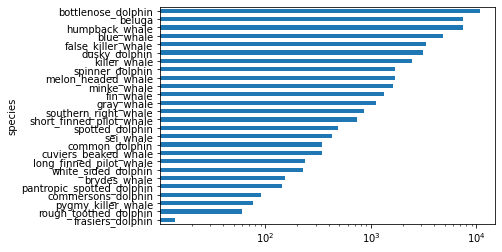

In [67]:
print(f"amount of species: {len(train_df.species.unique())}")
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [68]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Input Pipeline

In [69]:
IMG_SIZE = 64
BATCH_SIZE = 10
AMT_CLASSES = len(train_df.species.unique())

In [70]:
def process_img(img):
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32) / 255
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False, antialias=False,) 
    return img #tf.image.per_image_standardization(img)

def opencv_process_img(path):
    file_name = tf.strings.split(path, "\\")[-1].numpy().decode()
    image = cv2.imread("train_images/"+file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return tf.convert_to_tensor(image, dtype=tf.float32)
   
    
def get_label(path):
    file_name= tf.strings.split(path, "\\")[-1]
    label= train_df[train_df["image"]==file_name]["species"].to_numpy().squeeze()
    return tf.convert_to_tensor(label)

def process_path(path):
    img = process_img(tf.io.read_file(path))
    #img = opencv_process_img(path)
    label = get_label(path)
    return img, label

In [71]:
full_img = list(map('train_images/'.__add__,images))

dataset = tf.data.Dataset.list_files('train_images/*')
dataset = dataset.map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]))
# ,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False

In [72]:
image_count = dataset.cardinality().numpy()
train_size = int(image_count*0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(BATCH_SIZE) 
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(BATCH_SIZE)

### Benchmark Dataset

In [59]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [60]:
benchmark_ds = dataset.take(10)
benchmark(benchmark_ds)

  0%|                                                                                           | 0/10 [00:03<?, ?it/s]

KeyboardInterrupt



## Sequential Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_15 (Dense)            (None, 512)               6291968   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 26)                1690      
                                                                 
Total params: 6,466,138
Trainable params: 6,466,138
No

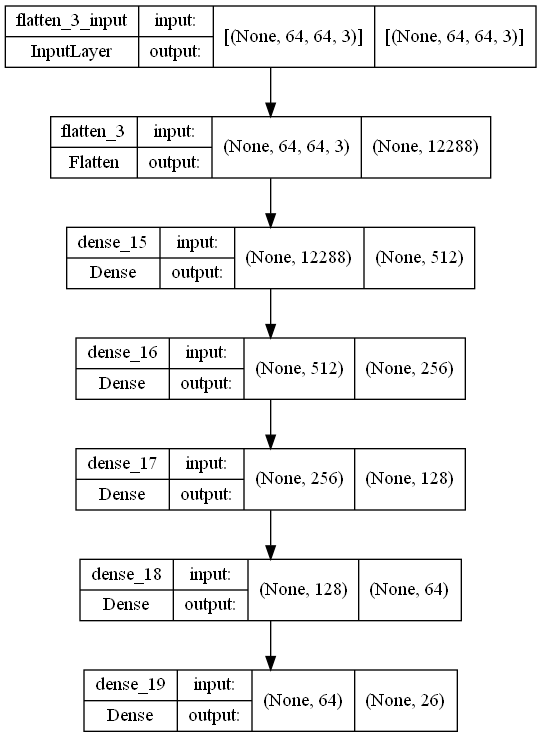

In [73]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[64, 64, 3]),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [74]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [75]:
model.fit(train_ds, epochs=1)

InvalidArgumentError: Graph execution error:

Detected at node 'strided_slice' defined at (most recent call last):
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\olive\AppData\Local\Temp\ipykernel_18804\3638608774.py", line 1, in <module>
      model.fit(train_ds, epochs=1)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "C:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 212, in __call__
      batch_dim = tf.shape(y_t)[0]
Node: 'strided_slice'
slice index 0 of dimension 0 out of bounds.
	 [[{{node strided_slice}}]] [Op:__inference_train_function_10729922]

## CNN

In [76]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    data_augmentation = keras.Sequential(
        [
            #version tf 2.4.1: 
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )
    # Image augmentation block
    x = data_augmentation(inputs)
    activation_str = "elu"
    # Entry block
    #version tf 2.4.1
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #-----------------
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['sequential_4[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                              

 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 4, 4, 512)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 4, 4, 512)    131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 4, 4, 512)    0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activation_8 (Activation)      (None, 4, 4, 512)    0           ['add_2[0][0]']                  
          

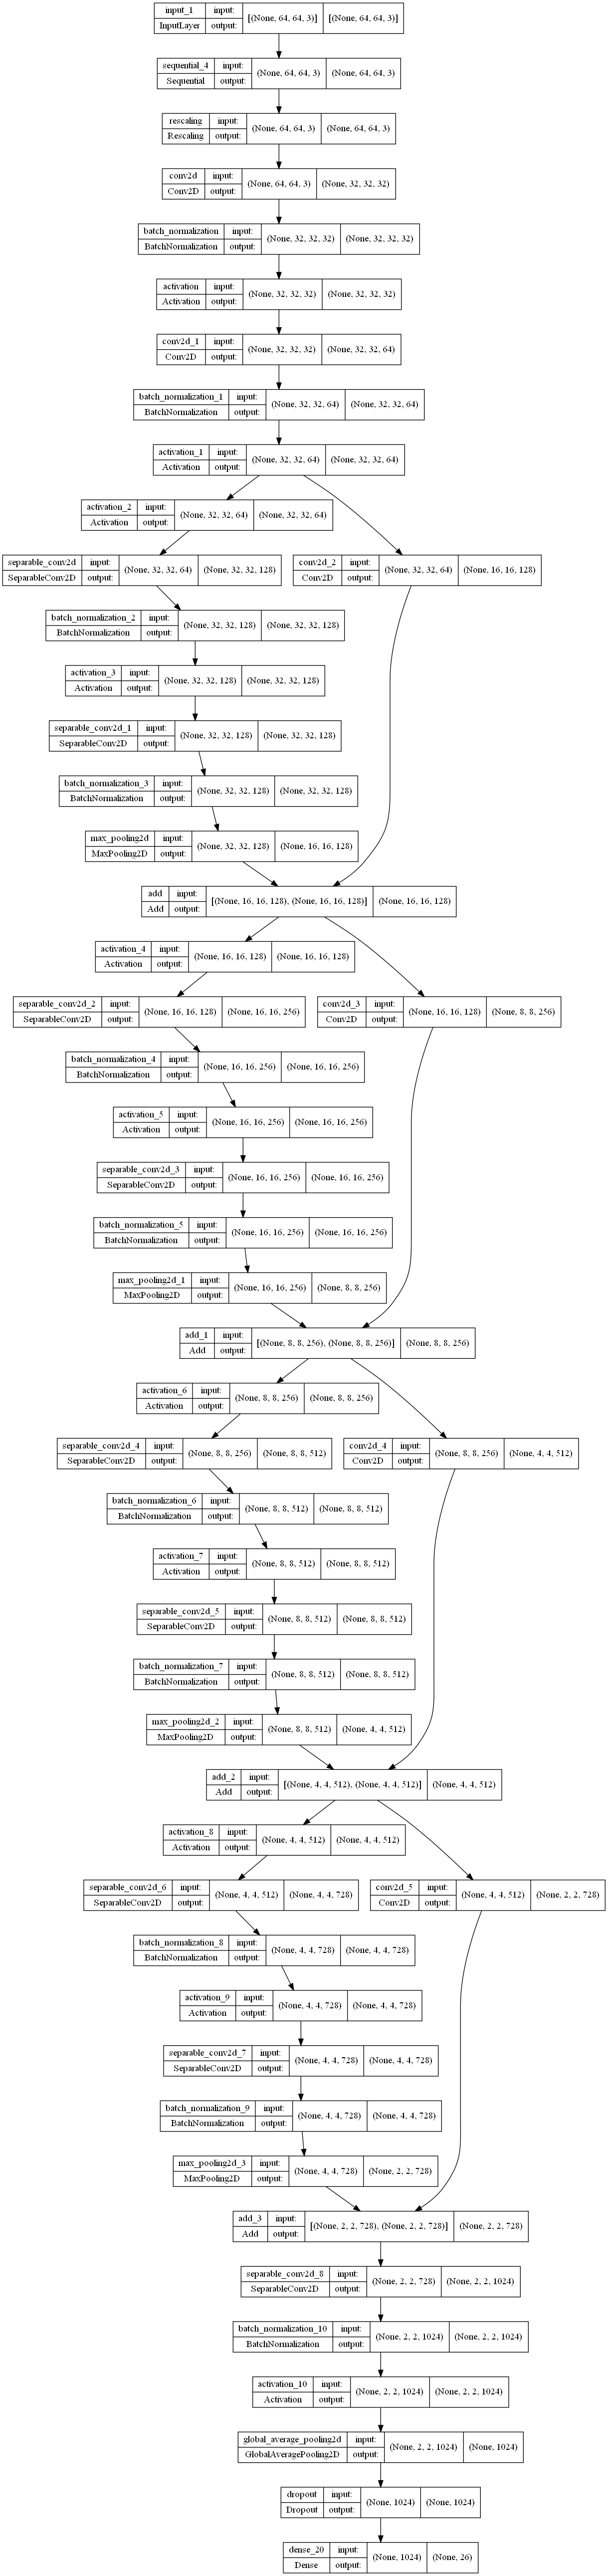

In [77]:
#creating model
cnnmodel = create_model([IMG_SIZE, IMG_SIZE, 3], AMT_CLASSES)
cnnmodel.summary()
plot_model(cnnmodel,show_shapes=True, show_layer_names=True)

In [78]:
#compiling model
cnnmodel.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
cnnmodel.fit(train_batched, epochs = 5)

Epoch 1/5
   2/4083 [..............................] - ETA: 40:59:25 - loss: 3.6572 - sparse_categorical_accuracy: 0.0000e+00

In [ ]:
cnnmodel.evaluate(test_batched)